# 1. Importing modules and functions

In [1]:
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem, Descriptors
from rdkit.ML.Descriptors import MoleculeDescriptors
from molvs import standardize_smiles
import numpy as np
import pandas as pd
from sklearn.svm import SVC
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.model_selection import permutation_test_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_predict
from sklearn import metrics
from sklearn.metrics import pairwise_distances
import joblib
import pickle
from numpy import savetxt
from padelpy import from_sdf
import shap
from tqdm.notebook import tqdm
import warnings
warnings.filterwarnings('ignore')

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [2]:
import glob
xml_files = glob.glob("fingerprints_xml/*.xml")
xml_files.sort()
xml_files

['fingerprints_xml\\AtomPairs2DFingerprintCount.xml',
 'fingerprints_xml\\AtomPairs2DFingerprinter.xml',
 'fingerprints_xml\\EStateFingerprinter.xml',
 'fingerprints_xml\\ExtendedFingerprinter.xml',
 'fingerprints_xml\\Fingerprinter.xml',
 'fingerprints_xml\\GraphOnlyFingerprinter.xml',
 'fingerprints_xml\\KlekotaRothFingerprintCount.xml',
 'fingerprints_xml\\KlekotaRothFingerprinter.xml',
 'fingerprints_xml\\MACCSFingerprinter.xml',
 'fingerprints_xml\\PubchemFingerprinter.xml',
 'fingerprints_xml\\SubstructureFingerprintCount.xml',
 'fingerprints_xml\\SubstructureFingerprinter.xml']

In [3]:
FP_list = ['AtomPairs2DCount',
 'AtomPairs2D',
 'EState',
 'CDKextended',
 'CDK',
 'CDKgraphonly',
 'KlekotaRothCount',
 'KlekotaRoth',
 'MACCS',
 'PubChem',
 'SubstructureCount',
 'Substructure']

In [4]:
fp = dict(zip(FP_list, xml_files))
fp

{'AtomPairs2DCount': 'fingerprints_xml\\AtomPairs2DFingerprintCount.xml',
 'AtomPairs2D': 'fingerprints_xml\\AtomPairs2DFingerprinter.xml',
 'EState': 'fingerprints_xml\\EStateFingerprinter.xml',
 'CDKextended': 'fingerprints_xml\\ExtendedFingerprinter.xml',
 'CDK': 'fingerprints_xml\\Fingerprinter.xml',
 'CDKgraphonly': 'fingerprints_xml\\GraphOnlyFingerprinter.xml',
 'KlekotaRothCount': 'fingerprints_xml\\KlekotaRothFingerprintCount.xml',
 'KlekotaRoth': 'fingerprints_xml\\KlekotaRothFingerprinter.xml',
 'MACCS': 'fingerprints_xml\\MACCSFingerprinter.xml',
 'PubChem': 'fingerprints_xml\\PubchemFingerprinter.xml',
 'SubstructureCount': 'fingerprints_xml\\SubstructureFingerprintCount.xml',
 'Substructure': 'fingerprints_xml\\SubstructureFingerprinter.xml'}

# 2.Data entry and curation work set

In [5]:
uploaded_file_ws="datasets/HDAC3_work.sdf"
supplier_ws = Chem.ForwardSDMolSupplier(uploaded_file_ws,sanitize=False)
failed_mols_ws = []
all_mols_ws =[]
wrong_structure_ws=[]
wrong_smiles_ws=[]
y_tr = []
y_bad_index=[]

for i, m in enumerate(supplier_ws):
    structure = Chem.Mol(m)
    all_mols_ws.append(structure)
    y_tr.append(m.GetProp("pchembl_value_mean"))
    try:
        Chem.SanitizeMol(structure)
    except:
        failed_mols_ws.append(m)
        wrong_smiles_ws.append(Chem.MolToSmiles(m))
        wrong_structure_ws.append(str(i+1))
        y_bad_index.append(i)
print('Original data: ', len(all_mols_ws), 'molecules')
print('Failed data: ', len(failed_mols_ws), 'molecules')
number_ws =[]
for i in range(len(failed_mols_ws)):
        number_ws.append(str(i+1))
bad_molecules_ws = pd.DataFrame({'No. failed molecule in original set': wrong_structure_ws, 'SMILES of wrong structure: ': wrong_smiles_ws, 'No.': number_ws}, index=None)
bad_molecules_ws = bad_molecules_ws.set_index('No.')
bad_molecules_ws

Original data:  1400 molecules
Failed data:  0 molecules


,No. failed molecule in original set,SMILES of wrong structure:
No.,,


deleting activity values for substances with incorrect structure

In [6]:
y_tr[:] = [x for i,x in enumerate(y_tr) if i not in y_bad_index]

In [7]:
len(y_tr)

1400

# 3.Standardization SDF file for work set

In [8]:
all_mols_ws[:] = [x for i,x in enumerate(all_mols_ws) if i not in y_bad_index] 
records = []
for i in range(len(all_mols_ws)):
    record = Chem.MolToSmiles(all_mols_ws[i])
    records.append(record)

moldf_ws = []
for i,record in enumerate(records):
    standard_record = standardize_smiles(record)
    m = Chem.MolFromSmiles(standard_record)
    moldf_ws.append(m)
    
print('Kept data: ', len(moldf_ws), 'molecules')

Kept data:  1400 molecules


In [9]:
records_ws = []
for i in range(len(moldf_ws)):
    record = Chem.MolToSmiles(moldf_ws[i])
    records_ws.append(record)

In [11]:
df = pd.DataFrame(records_ws, columns=["Smiles"])
df.to_csv('datasets/molecule_ws.smi', sep=',', index=False, header=False)

# 4.Data entry and curation test set

In [10]:
uploaded_file_ts="datasets/HDAC3_test.sdf"
supplier_ts = Chem.ForwardSDMolSupplier(uploaded_file_ts,sanitize=False)
failed_mols_ts = []
all_mols_ts =[]
wrong_structure_ts=[]
wrong_smiles_ts=[]
y_ts = []
y_bad_index=[]
for i, m in enumerate(supplier_ts):
    structure = Chem.Mol(m)
    all_mols_ts.append(structure)
    y_ts.append(m.GetProp("pchembl_value_mean"))
    try:
        Chem.SanitizeMol(structure)
    except:
        failed_mols_ts.append(m)
        wrong_smiles_ts.append(Chem.MolToSmiles(m))
        wrong_structure_ts.append(str(i+1))
        y_bad_index.append(i)
print('Original data: ', len(all_mols_ts), 'molecules')
print('Failed data: ', len(failed_mols_ts), 'molecules')
number_ts =[]
for i in range(len(failed_mols_ts)):
        number_ts.append(str(i+1))
bad_molecules_ts = pd.DataFrame({'No. failed molecule in original set': wrong_structure_ts, 'SMILES of wrong structure: ': wrong_smiles_ts, 'No.': number_ts}, index=None)
bad_molecules_ts = bad_molecules_ts.set_index('No.')
bad_molecules_ts

Original data:  351 molecules
Failed data:  0 molecules


,No. failed molecule in original set,SMILES of wrong structure:
No.,,


deleting activity values for substances with incorrect structure

In [11]:
y_ts[:] = [x for i,x in enumerate(y_ts) if i not in y_bad_index]

In [12]:
len(y_ts)

351

# 5.Standardization SDF file for test set

In [13]:
all_mols_ts[:] = [x for i,x in enumerate(all_mols_ts) if i not in y_bad_index] 
records = []
for i in range(len(all_mols_ts)):
    record = Chem.MolToSmiles(all_mols_ts[i])
    records.append(record)

moldf_ts = []
for i,record in enumerate(records):
    standard_record = standardize_smiles(record)
    m = Chem.MolFromSmiles(standard_record)
    moldf_ts.append(m)
    
print('Kept data: ', len(moldf_ts), 'molecules')

Kept data:  351 molecules


In [14]:
records_ts = []
for i in range(len(moldf_ts)):
    record = Chem.MolToSmiles(moldf_ts[i])
    records_ts.append(record)

In [17]:
df_ts = pd.DataFrame(records_ts, columns=["Smiles"])
df_ts.to_csv('datasets/molecule_ts.smi', sep=',', index=False, header=False)

# 6.Descriptor calculation for work set

In [15]:
fp

{'AtomPairs2DCount': 'fingerprints_xml\\AtomPairs2DFingerprintCount.xml',
 'AtomPairs2D': 'fingerprints_xml\\AtomPairs2DFingerprinter.xml',
 'EState': 'fingerprints_xml\\EStateFingerprinter.xml',
 'CDKextended': 'fingerprints_xml\\ExtendedFingerprinter.xml',
 'CDK': 'fingerprints_xml\\Fingerprinter.xml',
 'CDKgraphonly': 'fingerprints_xml\\GraphOnlyFingerprinter.xml',
 'KlekotaRothCount': 'fingerprints_xml\\KlekotaRothFingerprintCount.xml',
 'KlekotaRoth': 'fingerprints_xml\\KlekotaRothFingerprinter.xml',
 'MACCS': 'fingerprints_xml\\MACCSFingerprinter.xml',
 'PubChem': 'fingerprints_xml\\PubchemFingerprinter.xml',
 'SubstructureCount': 'fingerprints_xml\\SubstructureFingerprintCount.xml',
 'Substructure': 'fingerprints_xml\\SubstructureFingerprinter.xml'}

### PubChem FPs

In [110]:
from padelpy import padeldescriptor

fingerprint = 'KlekotaRoth'

fingerprint_output_file = ''.join([fingerprint,'.csv']) #Substructure.csv
fingerprint_descriptortypes = fp[fingerprint]

padeldescriptor(mol_dir='datasets/molecule_ws.smi', 
                d_file=fingerprint_output_file, #'Substructure.csv'
                #descriptortypes='SubstructureFingerprint.xml', 
                descriptortypes= fingerprint_descriptortypes,
                detectaromaticity=True,
                standardizenitro=True,
                standardizetautomers=True,
                threads=2,
                removesalt=True,
                log=True,
                fingerprints=True)

In [3]:
descriptors_PubChem = pd.read_csv('KlekotaRoth.csv')

In [4]:
descriptors_PubChem

,Name,KRFP1,KRFP2,KRFP3,KRFP4,KRFP5,KRFP6,KRFP7,KRFP8,KRFP9,...,KRFP4851,KRFP4852,KRFP4853,KRFP4854,KRFP4855,KRFP4856,KRFP4857,KRFP4858,KRFP4859,KRFP4860
0,AUTOGEN_molecule_ws_1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,AUTOGEN_molecule_ws_2,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,AUTOGEN_molecule_ws_3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,AUTOGEN_molecule_ws_4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,AUTOGEN_molecule_ws_5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1395,AUTOGEN_molecule_ws_1396,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1396,AUTOGEN_molecule_ws_1397,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1397,AUTOGEN_molecule_ws_1398,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1398,AUTOGEN_molecule_ws_1399,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
descriptors_PubChem[descriptors_PubChem['KRFP1236']==1]

,Name,KRFP1,KRFP2,KRFP3,KRFP4,KRFP5,KRFP6,KRFP7,KRFP8,KRFP9,...,KRFP4851,KRFP4852,KRFP4853,KRFP4854,KRFP4855,KRFP4856,KRFP4857,KRFP4858,KRFP4859,KRFP4860
213,AUTOGEN_molecule_ws_214,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
698,AUTOGEN_molecule_ws_699,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
712,AUTOGEN_molecule_ws_713,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
752,AUTOGEN_molecule_ws_753,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
817,AUTOGEN_molecule_ws_818,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1394,AUTOGEN_molecule_ws_1395,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1395,AUTOGEN_molecule_ws_1396,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1396,AUTOGEN_molecule_ws_1397,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1397,AUTOGEN_molecule_ws_1398,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [19]:
x_tr = descriptors_PubChem.drop('Name', axis=1)

In [20]:
x_tr = np.array(x_tr, dtype=np.float32)
y_tr = np.array(y_tr, dtype=np.float32)

In [246]:
savetxt('Models/Padels/x_tr_KlekotaRoth.csv', y_tr, delimiter=',')

In [60]:
x_tr.shape

(1400, 4860)

# 7.Descriptor calculation for test set

In [137]:
from padelpy import padeldescriptor

fingerprint = 'KlekotaRoth'

fingerprint_output_file = ''.join([fingerprint,'_ts.csv']) #Substructure.csv
fingerprint_descriptortypes = fp[fingerprint]

padeldescriptor(mol_dir='datasets/molecule_ts.smi', 
                d_file=fingerprint_output_file, #'PubChem.csv'
                #descriptortypes='PubChem.xml', 
                descriptortypes= fingerprint_descriptortypes,
                detectaromaticity=True,
                standardizenitro=True,
                standardizetautomers=True,
                threads=2,
                removesalt=True,
                log=False,
                fingerprints=True)

In [50]:
descriptors_PubChem_ts = pd.read_csv('KlekotaRoth_ts.csv')

In [51]:
x_ts = descriptors_PubChem_ts.drop('Name', axis=1)

In [59]:
x_ts.shape

(351, 4860)

 # GradientBoostingRegressor

In [61]:
seed = 42

In [62]:
cv=KFold(n_splits=5, random_state=seed, shuffle=True)

In [63]:
param_grid = {'learning_rate': [0.02,0.05],
                  'subsample'    : [0.9, 0.5, 0.1],
                  'n_estimators' : [100,500,1000],
                  'max_depth'    : [4, 10]
                 }

In [64]:
m = GridSearchCV(GradientBoostingRegressor(), param_grid, n_jobs=-1, cv=cv, verbose=1)

In [65]:
m.fit(x_tr, y_tr)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=GradientBoostingRegressor(), n_jobs=-1,
             param_grid={'learning_rate': [0.02, 0.05], 'max_depth': [4, 10],
                         'n_estimators': [100, 500, 1000],
                         'subsample': [0.9, 0.5, 0.1]},
             verbose=1)

In [66]:
best_GBR = m.best_estimator_

In [67]:
m.best_params_

{'learning_rate': 0.02,
 'max_depth': 10,
 'n_estimators': 1000,
 'subsample': 0.5}

In [68]:
y_pred_ws_GBR = best_GBR.predict(x_tr)

In [69]:
R2_WS = round(r2_score(y_tr, y_pred_ws_GBR), 2)
R2_WS

0.98

In [71]:
RMSE_WS=round(np.sqrt(mean_absolute_error(y_tr, y_pred_ws_GBR)), 2)
RMSE_WS

0.38

In [72]:
y_pred_CV_GBR = cross_val_predict(best_GBR, x_tr, y_tr, cv=cv)

In [73]:
y_pred_CV_GBR

array([5.46889995, 5.68046947, 4.45944809, ..., 9.51408977, 6.52766004,
       9.37563859])

In [74]:
Q2_CV = round(r2_score(y_tr, y_pred_CV_GBR), 2)
Q2_CV

0.67

In [75]:
RMSE_CV=round(np.sqrt(mean_absolute_error(y_tr, y_pred_CV_GBR)), 2)
RMSE_CV

0.71

# 9. Prediction for test set's molecules

In [76]:
x_ts = np.array(x_ts, dtype=np.float32)
y_ts = np.array(y_ts, dtype=np.float32)
len(y_ts)

351

In [77]:
y_pred_GBR = best_GBR.predict(x_ts)

In [78]:
Q2_TS = round(r2_score(y_ts, y_pred_GBR), 2)
Q2_TS

0.7

In [181]:
RMSE_TS=round(np.sqrt(mean_absolute_error(y_ts, y_pred_GBR)), 2)
RMSE_TS

0.71

# save the model to disk

In [79]:
pickle.dump(best_GBR, open('Models/Padels/HDAC3_GBR_KlekotaRoth.pkl', 'wb'))

# load the model from disk

In [57]:
best_GBR = pickle.load(open('Models/Padels/HDAC3_GBR_KlekotaRoth.pkl', 'rb'))

# Y-randomization GradientBoostingRegressor model

In [145]:
permutations = 50
score, permutation_scores, pvalue = permutation_test_score(best_GBR, x_tr, y_tr,
                                                           cv=cv, scoring='r2',
                                                           n_permutations=permutations,
                                                           n_jobs=-1,
                                                           verbose=1,
                                                           random_state=seed)
print('True score = ', score.round(2),
      '\nY-randomization = ', np.mean(permutation_scores).round(2),
      '\np-value = ', pvalue.round(4))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed: 88.3min


True score =  0.66 
Y-randomization =  -0.32 
p-value =  0.0196


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 139.6min finished


# 11. Estimating applicability domain. Method - Euclidian distances, K=1

In [176]:
neighbors_k= pairwise_distances(x_tr, n_jobs=-1)
neighbors_k.sort(0)

In [177]:
df_tr=pd.DataFrame(neighbors_k)
df_tr

,0,1,2,3,4,5,6,7,8,9,...,1390,1391,1392,1393,1394,1395,1396,1397,1398,1399
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,2.236068,3.464102,2.000000,2.449490,2.000000,2.000000,2.236068,6.164414,3.000000,5.099020,...,4.000000,2.645751,2.000000,1.732051,3.000000,2.645751,2.236068,1.414214,3.605551,2.828427
2,2.645751,3.741657,5.385165,2.449490,5.385165,2.828427,3.316625,6.633250,3.605551,5.196152,...,5.196152,2.828427,2.000000,2.000000,3.316625,2.645751,2.449490,2.236068,3.872983,3.000000
3,2.645751,3.741657,5.744563,2.828427,6.324555,3.872983,4.000000,6.708204,3.741657,6.164414,...,5.196152,3.000000,2.645751,2.000000,3.316625,3.162278,2.645751,2.236068,4.123106,3.000000
4,3.000000,4.123106,5.830952,3.162278,6.557438,3.872983,4.123106,6.782330,3.872983,6.244998,...,5.567764,3.316625,2.645751,2.000000,3.316625,3.162278,2.645751,2.236068,4.795832,3.162278
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1395,11.618950,11.874342,11.958261,11.958261,12.165525,12.649111,11.916375,12.041595,13.152946,12.449900,...,13.453624,12.922848,12.165525,11.916375,12.083046,11.789826,11.958261,11.916375,11.532562,12.041595
1396,11.704700,11.958261,12.041595,12.206555,12.206555,12.727922,11.958261,12.083046,13.190906,12.449900,...,13.490738,12.961481,12.206555,11.958261,12.165525,11.916375,12.041595,12.000000,11.532562,12.124355
1397,11.958261,12.165525,12.206555,12.247449,12.288206,13.000000,12.000000,12.124355,13.266500,12.489996,...,13.564660,13.038404,12.206555,12.000000,12.165525,11.916375,12.041595,12.041595,11.747340,12.124355
1398,12.083046,12.206555,12.247449,12.288206,12.489996,13.076696,12.206555,12.328828,13.453624,12.489996,...,13.674794,13.152946,12.409674,12.124355,12.369317,12.000000,12.083046,12.083046,11.747340,12.165525


In [178]:
similarity= neighbors_k

In [179]:
Dmean=np.mean(similarity[1,:])

In [180]:
round(Dmean, 2)

2.85

In [181]:
std=np.std(similarity[1,:])

In [182]:
round(std, 2)

1.38

In [183]:
model_AD_limit=Dmean+std*0.5
print(np.round(model_AD_limit, 2))

3.54


In [184]:
neighbors_k_ts= pairwise_distances(x_tr,Y=x_ts, n_jobs=-1)
neighbors_k_ts.sort(0)

In [185]:
x_ts_AD=pd.DataFrame(neighbors_k_ts)
x_ts_AD

,0,1,2,3,4,5,6,7,8,9,...,341,342,343,344,345,346,347,348,349,350
0,1.000000,4.898980,5.744563,2.828427,3.162278,3.316625,2.449490,3.464102,3.316625,3.605551,...,2.645751,2.828427,2.236068,2.449490,4.242640,1.732051,2.000000,2.828427,4.358899,3.605551
1,3.162278,5.656854,6.244998,4.358899,3.872983,4.242640,3.000000,3.464102,4.123106,4.795832,...,2.828427,2.828427,2.449490,2.449490,4.242640,2.000000,2.236068,2.828427,4.472136,3.741657
2,3.162278,5.830952,6.244998,4.472136,3.872983,4.358899,3.872983,4.000000,5.567764,5.000000,...,2.828427,3.000000,2.449490,2.645751,4.582576,2.000000,2.449490,3.000000,4.472136,3.872983
3,3.605551,5.830952,6.244998,4.690416,4.582576,5.830952,4.123106,5.744563,5.916080,5.099020,...,3.162278,3.000000,3.000000,3.316625,4.690416,2.236068,2.645751,3.000000,4.582576,4.000000
4,3.741657,5.830952,6.324555,6.082763,6.164414,5.830952,4.242640,6.244998,6.082763,5.830952,...,3.316625,3.162278,3.464102,3.316625,4.690416,2.236068,2.645751,3.162278,4.690416,4.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1395,11.916375,13.341664,12.206555,13.638182,12.845233,12.449900,13.304134,12.529964,12.288206,12.767145,...,13.152946,12.884099,12.922848,12.083046,12.328828,11.789826,12.083046,12.165525,12.124355,12.288206
1396,11.916375,13.379088,12.247449,13.674794,12.884099,12.569805,13.341664,12.569805,12.369317,12.806249,...,13.190906,12.922848,12.961481,12.165525,12.569805,11.832160,12.124355,12.206555,12.165525,12.288206
1397,12.206555,13.453624,12.328828,13.747727,12.961481,12.649111,13.416408,12.569805,12.449900,12.845233,...,13.266500,13.000000,13.038404,12.165525,12.649111,11.874342,12.124355,12.247449,12.206555,12.369317
1398,12.247449,13.638182,12.529964,13.928389,13.152946,12.806249,13.601471,12.884099,12.569805,13.152946,...,13.304134,13.114877,13.076696,12.206555,12.688578,12.000000,12.328828,12.369317,12.247449,12.409674


In [186]:
similarity_ts= neighbors_k_ts
cpd_AD=similarity_ts[0,:]
cpd_value = np.round(cpd_AD, 3)
print(cpd_value)

[1.    4.899 5.745 2.828 3.162 3.317 2.449 3.464 3.317 3.606 5.196 2.646
 1.732 3.873 3.742 1.732 2.236 3.464 4.899 2.    2.236 3.    6.557 2.449
 2.    2.449 4.243 2.646 2.236 2.    5.831 1.    3.464 2.449 2.    4.
 2.236 2.236 2.236 2.646 1.732 7.483 3.317 2.    2.236 2.236 4.472 3.742
 2.449 2.449 2.646 4.243 2.828 2.    2.236 6.245 4.243 1.732 2.    2.449
 0.    4.123 2.449 6.083 3.    2.236 4.796 2.    3.    4.899 4.69  2.828
 1.    2.449 2.646 1.732 2.449 3.162 3.873 4.243 1.414 2.    3.    2.449
 3.317 2.449 1.    3.    1.    7.28  3.    6.325 2.236 3.162 2.    3.742
 2.449 3.464 1.    3.162 7.    2.    2.    1.414 4.    3.    4.359 1.732
 3.873 1.414 1.732 3.606 2.646 2.828 2.449 2.449 2.646 2.449 3.162 1.732
 3.162 4.583 4.    3.606 3.162 3.464 2.828 2.    2.646 4.243 2.828 4.583
 1.    3.    2.    2.646 2.646 2.646 4.243 3.    5.745 2.646 2.828 3.606
 3.317 2.828 2.    2.449 1.    5.657 3.317 2.646 2.236 2.646 2.646 4.
 3.317 3.464 2.646 2.828 3.742 1.414 2.236 3.162 1.732 2.

In [187]:
cpd_AD = np.where(cpd_value <= model_AD_limit, True, False)
print(cpd_AD)

[ True False False  True  True  True  True  True  True False False  True
  True False False  True  True  True False  True  True  True False  True
  True  True False  True  True  True False  True  True  True  True False
  True  True  True  True  True False  True  True  True  True False False
  True  True  True False  True  True  True False False  True  True  True
  True False  True False  True  True False  True  True False False  True
  True  True  True  True  True  True False False  True  True  True  True
  True  True  True  True  True False  True False  True  True  True False
  True  True  True  True False  True  True  True False  True False  True
 False  True  True False  True  True  True  True  True  True  True  True
  True False False False  True  True  True  True  True False  True False
  True  True  True  True  True  True False  True False  True  True False
  True  True  True  True  True False  True  True  True  True  True False
  True  True  True  True False  True  True  True  T

In [188]:
print("Coverage = ", round(sum(cpd_AD) / len(cpd_AD), 2))

Coverage =  0.78


In [189]:
print("Indices of substances included in AD = ", np.where(cpd_AD != 0)[0])

Indices of substances included in AD =  [  0   3   4   5   6   7   8  11  12  15  16  17  19  20  21  23  24  25
  27  28  29  31  32  33  34  36  37  38  39  40  42  43  44  45  48  49
  50  52  53  54  57  58  59  60  62  64  65  67  68  71  72  73  74  75
  76  77  80  81  82  83  84  85  86  87  88  90  92  93  94  96  97  98
  99 101 102 103 105 107 109 110 112 113 114 115 116 117 118 119 120 124
 125 126 127 128 130 132 133 134 135 136 137 139 141 142 144 145 146 147
 148 150 151 152 153 154 156 157 158 159 161 162 163 164 165 166 167 168
 169 170 171 172 173 174 177 178 179 180 183 184 185 186 187 188 189 190
 191 192 193 194 195 197 198 199 201 202 203 204 205 206 207 208 209 210
 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 227 228 230
 232 233 234 235 237 238 240 242 244 246 247 248 249 250 251 252 254 255
 256 257 258 259 260 261 263 264 265 266 267 268 269 270 271 272 274 275
 277 278 280 281 282 283 284 286 287 289 291 292 295 296 297 298 299 301
 303 304 30

In [190]:
out_Ad=list(np.where(cpd_AD == 0)[0])

#  Prediction only for molecules included in  AD

In [191]:
y_pred_GBR_ad=list(y_pred_GBR)

In [192]:
y_pred_GBR_ad[:] = [x for i,x in enumerate(y_pred_GBR_ad) if i not in out_Ad]

In [193]:
len(y_pred_GBR_ad)

273

In [194]:
y_ts_ad=list(y_ts)

In [195]:
y_ts_ad[:] = [x for i,x in enumerate(y_ts_ad) if i not in out_Ad]

In [196]:
len(y_ts_ad)

273

In [197]:
Q2_TS = round(r2_score(y_ts_ad, y_pred_GBR_ad), 2)
Q2_TS

0.75

In [198]:
RMSE_TS=round(np.sqrt(mean_absolute_error(y_ts_ad, y_pred_GBR_ad)), 2)
RMSE_TS

0.67

# SVM model building and validation

In [169]:
param_grid = {"C": [10 ** i for i in range(0, 5)],
              "gamma": [10 ** i for i in range(-6, 0)]}

In [170]:
seed = 42
cv=KFold(n_splits=5, random_state=seed, shuffle=True)

In [171]:
svm = GridSearchCV(SVR(C=1.0, epsilon=0.2), param_grid, n_jobs=-1, cv=cv, verbose=1)

In [172]:
svm.fit(x_tr, y_tr)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=SVR(epsilon=0.2), n_jobs=-1,
             param_grid={'C': [1, 10, 100, 1000, 10000],
                         'gamma': [1e-06, 1e-05, 0.0001, 0.001, 0.01, 0.1]},
             verbose=1)

In [199]:
svm.best_params_
best_svm = svm.best_estimator_

In [200]:
svm.best_params_

{'C': 10, 'gamma': 0.01}

In [201]:
y_pred_ws_svm = best_svm.predict(x_tr)

In [202]:
R2_WS = round(r2_score(y_tr, y_pred_ws_svm), 2)
R2_WS

0.93

In [203]:
RMSE_WS=round(np.sqrt(mean_absolute_error(y_tr, y_pred_ws_svm)), 2)
RMSE_WS

0.48

In [204]:
y_pred_CV_svm = cross_val_predict(best_svm, x_tr, y_tr, cv=cv)

In [205]:
Q2_CV = round(r2_score(y_tr, y_pred_CV_svm), 2)
Q2_CV

0.66

In [206]:
RMSE_CV=round(np.sqrt(mean_absolute_error(y_tr, y_pred_CV_svm)), 2)
RMSE_CV

0.72

#  Prediction for test set's molecules

In [207]:
x_ts = np.array(x_ts, dtype=np.float32)
y_ts = np.array(y_ts, dtype=np.float32)

In [208]:
y_pred_svm = best_svm.predict(x_ts)

In [209]:
Q2_TS = round(r2_score(y_ts, y_pred_svm), 2)
Q2_TS

0.7

In [210]:
RMSE_TS=round(np.sqrt(mean_absolute_error(y_ts, y_pred_svm)), 2)
RMSE_TS

0.72

save the model to disk

In [212]:
pickle.dump(best_svm, open('Models/Padels/HDAC3_SVM_KlekotaRoth.pkl', 'wb'))

load the model from disk

In [31]:
best_svm = pickle.load(open('Models/Padels/HDAC3_SVM_KlekotaRoth.pkl', 'rb'))

# 10. Y-randomization SVM model

In [213]:
permutations = 50
score, permutation_scores, pvalue = permutation_test_score(best_svm, x_tr, y_tr,
                                                           cv=cv, scoring='r2',
                                                           n_permutations=permutations,
                                                           n_jobs=-1,
                                                           verbose=1,
                                                           random_state=seed)
print('True score = ', score.round(3),
      '\nY-randomization = ', np.mean(permutation_scores).round(2),
      '\np-value = ', pvalue.round(4))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:  6.3min


True score =  0.659 
Y-randomization =  -0.26 
p-value =  0.0196


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 10.4min finished


# 11. Estimating applicability domain. Method - Euclidian distances, K=1

In [214]:
neighbors_k= pairwise_distances(x_tr, n_jobs=-1)
neighbors_k.sort(0)

In [215]:
df_tr=pd.DataFrame(neighbors_k)
df_tr

,0,1,2,3,4,5,6,7,8,9,...,1390,1391,1392,1393,1394,1395,1396,1397,1398,1399
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,2.236068,3.464102,2.000000,2.449490,2.000000,2.000000,2.236068,6.164414,3.000000,5.099020,...,4.000000,2.645751,2.000000,1.732051,3.000000,2.645751,2.236068,1.414214,3.605551,2.828427
2,2.645751,3.741657,5.385165,2.449490,5.385165,2.828427,3.316625,6.633250,3.605551,5.196152,...,5.196152,2.828427,2.000000,2.000000,3.316625,2.645751,2.449490,2.236068,3.872983,3.000000
3,2.645751,3.741657,5.744563,2.828427,6.324555,3.872983,4.000000,6.708204,3.741657,6.164414,...,5.196152,3.000000,2.645751,2.000000,3.316625,3.162278,2.645751,2.236068,4.123106,3.000000
4,3.000000,4.123106,5.830952,3.162278,6.557438,3.872983,4.123106,6.782330,3.872983,6.244998,...,5.567764,3.316625,2.645751,2.000000,3.316625,3.162278,2.645751,2.236068,4.795832,3.162278
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1395,11.618950,11.874342,11.958261,11.958261,12.165525,12.649111,11.916375,12.041595,13.152946,12.449900,...,13.453624,12.922848,12.165525,11.916375,12.083046,11.789826,11.958261,11.916375,11.532562,12.041595
1396,11.704700,11.958261,12.041595,12.206555,12.206555,12.727922,11.958261,12.083046,13.190906,12.449900,...,13.490738,12.961481,12.206555,11.958261,12.165525,11.916375,12.041595,12.000000,11.532562,12.124355
1397,11.958261,12.165525,12.206555,12.247449,12.288206,13.000000,12.000000,12.124355,13.266500,12.489996,...,13.564660,13.038404,12.206555,12.000000,12.165525,11.916375,12.041595,12.041595,11.747340,12.124355
1398,12.083046,12.206555,12.247449,12.288206,12.489996,13.076696,12.206555,12.328828,13.453624,12.489996,...,13.674794,13.152946,12.409674,12.124355,12.369317,12.000000,12.083046,12.083046,11.747340,12.165525


In [216]:
similarity= neighbors_k

In [217]:
Dmean=np.mean(similarity[1,:])

In [218]:
round(Dmean, 2)

2.85

In [219]:
std=np.std(similarity[1,:])

In [220]:
round(std, 2)

1.38

In [221]:
model_AD_limit=Dmean+std*0.5
print(np.round(model_AD_limit, 2))

3.54


In [222]:
neighbors_k_ts= pairwise_distances(x_tr,Y=x_ts, n_jobs=-1)
neighbors_k_ts.sort(0)

In [223]:
x_ts_AD=pd.DataFrame(neighbors_k_ts)
x_ts_AD

,0,1,2,3,4,5,6,7,8,9,...,341,342,343,344,345,346,347,348,349,350
0,1.000000,4.898980,5.744563,2.828427,3.162278,3.316625,2.449490,3.464102,3.316625,3.605551,...,2.645751,2.828427,2.236068,2.449490,4.242640,1.732051,2.000000,2.828427,4.358899,3.605551
1,3.162278,5.656854,6.244998,4.358899,3.872983,4.242640,3.000000,3.464102,4.123106,4.795832,...,2.828427,2.828427,2.449490,2.449490,4.242640,2.000000,2.236068,2.828427,4.472136,3.741657
2,3.162278,5.830952,6.244998,4.472136,3.872983,4.358899,3.872983,4.000000,5.567764,5.000000,...,2.828427,3.000000,2.449490,2.645751,4.582576,2.000000,2.449490,3.000000,4.472136,3.872983
3,3.605551,5.830952,6.244998,4.690416,4.582576,5.830952,4.123106,5.744563,5.916080,5.099020,...,3.162278,3.000000,3.000000,3.316625,4.690416,2.236068,2.645751,3.000000,4.582576,4.000000
4,3.741657,5.830952,6.324555,6.082763,6.164414,5.830952,4.242640,6.244998,6.082763,5.830952,...,3.316625,3.162278,3.464102,3.316625,4.690416,2.236068,2.645751,3.162278,4.690416,4.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1395,11.916375,13.341664,12.206555,13.638182,12.845233,12.449900,13.304134,12.529964,12.288206,12.767145,...,13.152946,12.884099,12.922848,12.083046,12.328828,11.789826,12.083046,12.165525,12.124355,12.288206
1396,11.916375,13.379088,12.247449,13.674794,12.884099,12.569805,13.341664,12.569805,12.369317,12.806249,...,13.190906,12.922848,12.961481,12.165525,12.569805,11.832160,12.124355,12.206555,12.165525,12.288206
1397,12.206555,13.453624,12.328828,13.747727,12.961481,12.649111,13.416408,12.569805,12.449900,12.845233,...,13.266500,13.000000,13.038404,12.165525,12.649111,11.874342,12.124355,12.247449,12.206555,12.369317
1398,12.247449,13.638182,12.529964,13.928389,13.152946,12.806249,13.601471,12.884099,12.569805,13.152946,...,13.304134,13.114877,13.076696,12.206555,12.688578,12.000000,12.328828,12.369317,12.247449,12.409674


In [224]:
similarity_ts= neighbors_k_ts
cpd_AD=similarity_ts[0,:]
cpd_value = np.round(cpd_AD, 3)
print(cpd_value)

[1.    4.899 5.745 2.828 3.162 3.317 2.449 3.464 3.317 3.606 5.196 2.646
 1.732 3.873 3.742 1.732 2.236 3.464 4.899 2.    2.236 3.    6.557 2.449
 2.    2.449 4.243 2.646 2.236 2.    5.831 1.    3.464 2.449 2.    4.
 2.236 2.236 2.236 2.646 1.732 7.483 3.317 2.    2.236 2.236 4.472 3.742
 2.449 2.449 2.646 4.243 2.828 2.    2.236 6.245 4.243 1.732 2.    2.449
 0.    4.123 2.449 6.083 3.    2.236 4.796 2.    3.    4.899 4.69  2.828
 1.    2.449 2.646 1.732 2.449 3.162 3.873 4.243 1.414 2.    3.    2.449
 3.317 2.449 1.    3.    1.    7.28  3.    6.325 2.236 3.162 2.    3.742
 2.449 3.464 1.    3.162 7.    2.    2.    1.414 4.    3.    4.359 1.732
 3.873 1.414 1.732 3.606 2.646 2.828 2.449 2.449 2.646 2.449 3.162 1.732
 3.162 4.583 4.    3.606 3.162 3.464 2.828 2.    2.646 4.243 2.828 4.583
 1.    3.    2.    2.646 2.646 2.646 4.243 3.    5.745 2.646 2.828 3.606
 3.317 2.828 2.    2.449 1.    5.657 3.317 2.646 2.236 2.646 2.646 4.
 3.317 3.464 2.646 2.828 3.742 1.414 2.236 3.162 1.732 2.

In [225]:
cpd_AD = np.where(cpd_value <= model_AD_limit, True, False)
print(cpd_AD)

[ True False False  True  True  True  True  True  True False False  True
  True False False  True  True  True False  True  True  True False  True
  True  True False  True  True  True False  True  True  True  True False
  True  True  True  True  True False  True  True  True  True False False
  True  True  True False  True  True  True False False  True  True  True
  True False  True False  True  True False  True  True False False  True
  True  True  True  True  True  True False False  True  True  True  True
  True  True  True  True  True False  True False  True  True  True False
  True  True  True  True False  True  True  True False  True False  True
 False  True  True False  True  True  True  True  True  True  True  True
  True False False False  True  True  True  True  True False  True False
  True  True  True  True  True  True False  True False  True  True False
  True  True  True  True  True False  True  True  True  True  True False
  True  True  True  True False  True  True  True  T

In [226]:
print("Coverage = ", round(sum(cpd_AD) / len(cpd_AD), 2))

Coverage =  0.78


In [227]:
print("Indices of substances included in AD = ", np.where(cpd_AD != 0)[0])

Indices of substances included in AD =  [  0   3   4   5   6   7   8  11  12  15  16  17  19  20  21  23  24  25
  27  28  29  31  32  33  34  36  37  38  39  40  42  43  44  45  48  49
  50  52  53  54  57  58  59  60  62  64  65  67  68  71  72  73  74  75
  76  77  80  81  82  83  84  85  86  87  88  90  92  93  94  96  97  98
  99 101 102 103 105 107 109 110 112 113 114 115 116 117 118 119 120 124
 125 126 127 128 130 132 133 134 135 136 137 139 141 142 144 145 146 147
 148 150 151 152 153 154 156 157 158 159 161 162 163 164 165 166 167 168
 169 170 171 172 173 174 177 178 179 180 183 184 185 186 187 188 189 190
 191 192 193 194 195 197 198 199 201 202 203 204 205 206 207 208 209 210
 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 227 228 230
 232 233 234 235 237 238 240 242 244 246 247 248 249 250 251 252 254 255
 256 257 258 259 260 261 263 264 265 266 267 268 269 270 271 272 274 275
 277 278 280 281 282 283 284 286 287 289 291 292 295 296 297 298 299 301
 303 304 30

In [228]:
out_Ad=list(np.where(cpd_AD == 0)[0])

# 12. Prediction only for molecules included in  AD

In [229]:
y_pred_svm_ad=list(y_pred_svm)

In [230]:
y_pred_svm_ad[:] = [x for i,x in enumerate(y_pred_svm_ad) if i not in out_Ad]

In [231]:
len(y_pred_svm_ad)

273

In [232]:
y_ts_ad=list(y_ts)

In [233]:
y_ts_ad[:] = [x for i,x in enumerate(y_ts_ad) if i not in out_Ad]

In [234]:
len(y_ts_ad)

273

In [235]:
Q2_TS = round(r2_score(y_ts_ad, y_pred_svm_ad), 2)
Q2_TS

0.74

In [236]:
RMSE_TS=round(np.sqrt(mean_absolute_error(y_ts_ad, y_pred_svm_ad)), 2)
RMSE_TS

0.68

## Analyzing the importance of descriptors for the GBM model

In [237]:
import shap

In [238]:
explainer = shap.Explainer(best_GBR)

In [239]:
shap_values = explainer(x_tr)

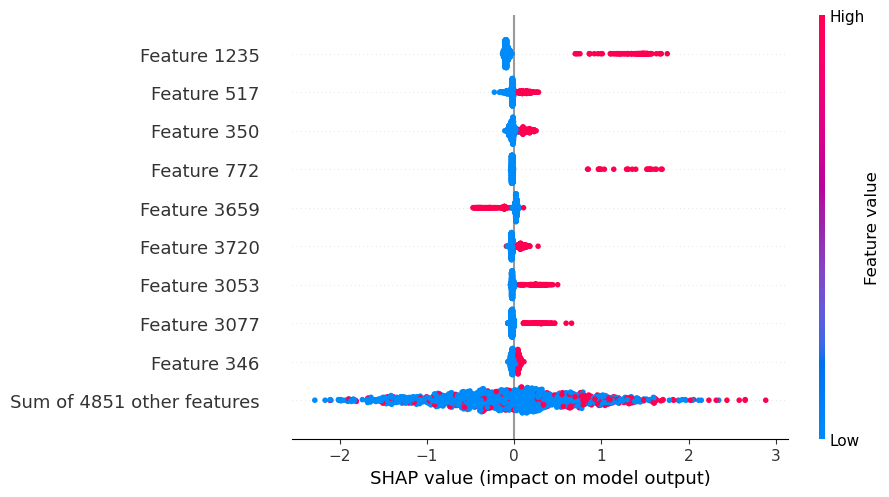

In [240]:
shap.plots.beeswarm(shap_values)

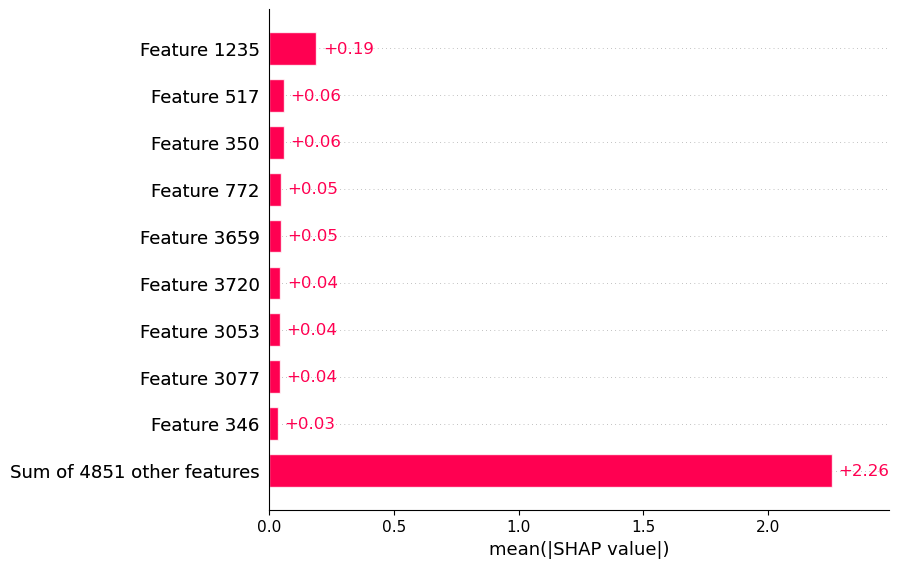

In [241]:
shap.plots.bar(shap_values)